# Análisis S&P500

Un análisis del SP500 en el periodo 2000-2021 donde se pretende dar respuesta a las siguientes preguntas:

+ Cual fue el mejor día para invertir teniendo en cuenta el retorno de los movimiento gap?

+ Cual fue el mejor día para invertir teniendo en cuenta el retorno de los movimientos intradiarios?

+ Cuales fueron las mejores industrias que pertenecen al SP500 en las cuales se puede invertir?

+ Cuales fueron los momentos de alta volatilidad que afectaron al SP500?

+ Cuales fueron las 9 mejores empresas para invertir?

In [3]:
#Importamos las librerias que vamos a utilizar para el análisis:
import pandas as pd
import numpy as np
import yfinance as yf
import bs4 as bs
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

### Cual fue el mejor día para invertir teniendo en cuenta el retorno de los movimiento gap?




In [9]:
#Descargamos las cotizaciones historicas del S&P500 mediante yfinance:
sp500 = yf.download("SPY", start="2000-01-01", end="2021-12-31")

#Seteamos "Date" como índice:
sp500["Date"] = sp500.index

# Creamos la columna "Day" con el dia de la semana al que corresponde cada registro:
sp500["Day"] = sp500["Date"].dt.dayofweek

# Creamos la columna "retornos_gaps" con las variaciones entre el cierre y la apertura siguiente:
sp500["retornos_gaps"] = np.log(sp500["Open"]/sp500["Close"].shift(1)).fillna(0)

# Establecemos un nuevo dataframe con los promedios de la columna "retornos_gaps" agrupados por día:
ret_sp = pd.DataFrame(sp500.groupby('Day')['retornos_gaps'].mean())

# Realizamos modificaciones al dataframe para una mejor visualización:
ret_sp['retornos_gaps'] = round(ret_sp['retornos_gaps']*100,2)
ret_sp = ret_sp.transpose()
ret_sp

[*********************100%***********************]  1 of 1 completed


Day,0,1,2,3,4
retornos_gaps,0.01,0.06,0.01,0.02,-0.01


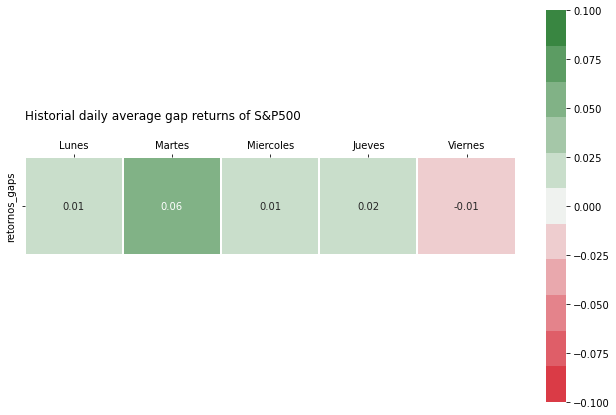

In [10]:
# figura:
fig, ax = plt.subplots(figsize=(11, 9))

# plot heatmap:
sb.heatmap(ret_sp, cmap=sb.diverging_palette(10, 130, n=11), vmin= -0.1, vmax=0.1, square=True,
           linewidth=0.3, annot=True , cbar_kws={"shrink": .8})

# xticks
ax.xaxis.tick_top()
xticks_labels = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes']
plt.xticks(np.arange(5) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('')
plt.ylabel('')

# title
title = 'Historial daily average gap returns of S&P500 \n'
plt.title(title, loc='left')
plt.show()

Según el analisis realizado, si bien las diferencias no son significativas, el mejor día para invertir solo teniendo en cuenta los rendimientos gap es el martes, con un retorno promedio en el periodo bajo estudio de 0.06%. Por otro lado, el peor dia para realizar esta estrategia es el viernes, con un retorno promedio en el periodo bajo estudio de un -0.01%.

Si bien la estrategia "buy the close, sell the open" parece funcionar en la teoría, se deben tener en cuenta varios factores que merman drasticamente sus resultados:

![buy the close sell the open strategy](https://github.com/facundoallia/analisisSP500/blob/main/asset/strategy.png?raw=true)

* Deslizamiento o Slippage: Hace referencia a la diferencia entre el precio al que se ordena una operación y el precio al que se ejecuta finalmente. Es poco probable operar al mejor precio en la apertura, principalmente cuando se producen eventos de volatilidad o se operan activos poco liquidos.

* Costo operativo: La estrategia sobreopera llevando a incurrir en costos operativos elevados. Si se tiene en consideración una comisión de 0.01% la estrategia deja de ser rentable, por lo que se recomendaría un contratar un servicio con esquema de comisiones flat fee en caso de implementarla.

* Por ultimo la estrategia no tiene en cuenta métricas de exposición al riesgo: Operar acciones individuales mediante esta estrategia podría exponernos a un riesgo muy elevado, principalmente en las ruedas previas a la presentación de resultados o eventos significativos para la empresa en cuestión. Aplicar la estrategia en índices o carteras bien diversificadas (con correlación baja entre sus activos) reduciria notablemente la exposición al riesgo no sistemático.

### Cual fue el mejor día para invertir teniendo en cuenta el retorno de los movimientos intradiarios?


In [102]:
# Definimos la columna "retornos_intra" para los rendimientos intradiarios
sp500["retornos_intra"] = np.log(sp500["Close"]/sp500["Open"]).fillna(0)

# Añadimos el promedio de los rendimientos intradiarios agrupados por dia al dataframe "ret_sp"
ret_sp = ret_sp.transpose()
ret_sp['retornos_intra'] = pd.DataFrame(sp500.groupby('Day')['retornos_intra'].mean())
ret_sp['retornos_intra'] = round(ret_sp['retornos_intra']*100,2)
ret_sp = ret_sp.transpose()
ret_sp

Day,0,1,2,3,4
retornos_gaps,0.01000,0.06000,0.01000,0.02000,-0.01000
retornos_intra,0.00000,0.00000,0.02000,0.01000,-0.03000


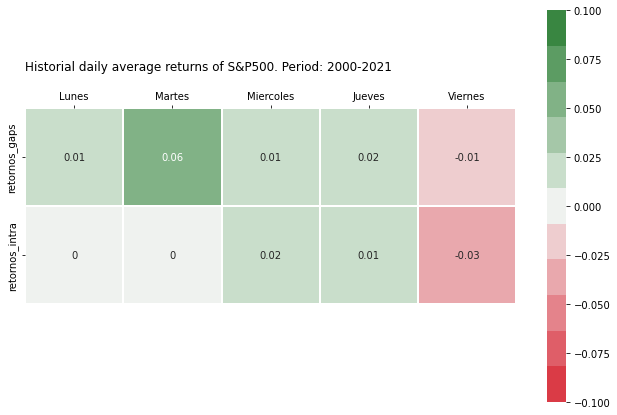

In [81]:
# figure
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sb.heatmap(ret_sp, cmap=sb.diverging_palette(10, 130, n=11), vmin= -0.1, vmax=0.1, square=True,
           linewidth=0.3, annot=True , cbar_kws={"shrink": .8})
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes']
yticks_labels = ['Promedio de retornos overnight', 'Promedio de retornos intraday']

plt.xticks(np.arange(5) + .5, labels=xticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Historial daily average returns of S&P500. Period: 2000-2021 \n'
plt.title(title, loc='left')
plt.show()

Las mismas consideraciones que fueron presentadas para la estrategia "buy the close, sell the open" deben ser tenidas en cuenta para la segunda estrategia

### Cuales fueron las 9 mejores empresas para invertir?

Para determinar las mejores empresas para invertir en el periodo bajo estudio analizaremos los retornos historicos de las acciones que componen el índice S&P500:

In [121]:
#Obtenemos la lista de tickers de las empresas que componenen el SP&500 mediante scraping:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]

#Seteamos los valores de fecha y descargamos las cotizaciones de todos los tickers por medio de la libreria yfinance:
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2021,12,31)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  503 of 503 completed

1 Failed download:
- CEG: Data doesn't exist for startDate = 946695600, endDate = 1640919600


In [122]:
# Reseteamos el índice para obtener las fechas en columna y eliminamos los registros que no corresponden:
data = data.reset_index()
data = data.drop(data.index[[5535,5536]])

print(data.head(5))

        Date Adj Close                                                    ...  \
                     A AAL AAP    AAPL ABBV     ABC     ABMD     ABT ACN  ...   
0 1999-12-31       NaN NaN NaN     NaN  NaN     NaN      NaN     NaN NaN  ...   
1 2000-01-03  44.22135 NaN NaN 0.85454  NaN 3.01669 18.25000 9.34785 NaN  ...   
2 2000-01-04  40.84332 NaN NaN 0.78249  NaN 2.81073 17.81250 9.08077 NaN  ...   
3 2000-01-05  38.30980 NaN NaN 0.79394  NaN 3.02881 18.00000 9.06407 NaN  ...   
4 2000-01-06  36.85111 NaN NaN 0.72524  NaN 3.25900 18.03125 9.38123 NaN  ...   

  Volume                                                                   \
    WYNN           XEL            XOM          XRAY XYL           YUM ZBH   
0    NaN           NaN            NaN           NaN NaN           NaN NaN   
1    NaN 2738600.00000 13458200.00000  582300.00000 NaN 3033493.00000 NaN   
2    NaN  425200.00000 14510800.00000  317700.00000 NaN 3315031.00000 NaN   
3    NaN  500200.00000 17485000.00000 1188000.0

In [ ]:
# Creamos un dataframe que contiene el porcentaje de cambio diario de cada acción:
multpl_stock_daily_returns = data['Adj Close'].pct_change()
multpl_stock_daily_returns.set_index(data["Date"])

# Definimos un dataframe que contiene el porcentaje de cambio diario de cada acción acumulado:
sp500_cum_ret = (multpl_stock_daily_returns + 1).cumprod()

# Obtenemos otro dataframe con el retorno acumulado al final del periódo bajo estudio:
cum_final_ret = sp500_cum_ret.loc[[5534]]
cum_final_ret = cum_final_ret.transpose()
cum_final_ret = cum_final_ret.reset_index()
cum_final_ret.columns = ["Tickers","Cumulative final return"]

# Ordenamos los datos por la columna"Cumulative final return" obteniendo un ranking con las 9 empresas con mayores retornos:
cum_final_ret = cum_final_ret.sort_values("Cumulative final return", ascending=False)
cum_final_ret.head(9)

,Tickers,Cumulative final return
305,MNST,1061.72917
327,NFLX,511.59745
346,ODFL,367.41974
339,NVDA,330.24365
446,TSCO,271.74698
447,TSLA,224.01423
3,AAPL,207.96210
244,ISRG,179.16163
232,IDXX,164.68669
36,ANSS,146.68655


Obtenemos así las 9 mejores empresas para haber invertido en el periodo bajo estudio. Si hubieramos invertido en Monster al inicio del periodo hubieramos multiplicado nuestra inversión por mas de 1000

![best stocks of SP500 index 2000-2021 period](https://github.com/facundoallia/analisisSP500/blob/main/asset/top_stocks.png?raw=true)

### Cuales fueron las mejores industrias que pertenecen al SP500 en las cuales se puede invertir?

Para responder esta pregunta agruparemos las acciones del S&P500 en los 11 sectores en los que se divide y compararemos sus retornos acumulados en el período analizado:

In [63]:
# Definimos la serie "sectors" donde introducimos los sectores a los que pertenece cada empresa mediante scrapping
sectors = []
for row in table.findAll('tr')[1:]:
    sector = row.findAll('td')[3].text
    sectors.append(sector)

# Creamos el dataframe "df_sectors" donde asociamos cada sector a su ticker y su retorno acumulado del período:
df_sectors = pd.DataFrame(list(zip(tickers,sectors)), columns=["Tickers","Sectors"])
df_sectors = df_sectors.merge(cum_final_ret)

# Obtenemos el promedio de los retornos acumulados por sector y ordenamos el dataframe para obtener un ranking:
top_sectors = pd.DataFrame(df_sectors.groupby(["Sectors"])["Cumulative final return"].mean())
top_sectors = top_sectors.reset_index()
top_sectors.columns = ["Sectors","Average cumulative final return by sector"]
top_sectors = top_sectors.sort_values("Average cumulative final return by sector",ascending=False)
top_sectors

,Sectors,Average cumulative final return by sector
2,Consumer Staples,42.31733
1,Consumer Discretionary,34.10908
0,Communication Services,30.85288
5,Health Care,29.73554
7,Information Technology,25.79638
6,Industrials,22.45885
9,Real Estate,17.08185
8,Materials,14.30898
4,Financials,12.28338
10,Utilities,10.06246


![best sectors of SP500 index 2000-2021 period](https://github.com/facundoallia/analisisSP500/blob/main/asset/sectors.png?raw=true)

El sector que presento mejores resultados en el período analizado es "Consumer Staples" seguido por "Consumer Discretionary" y "Communication Services". Por otro lado los sectores que menos rentabilidad ofrecieron fueron "Financials", "Utilities" y "Energy"

### Cuales fueron los momentos de alta volatilidad que afectaron al SP500?

Para determinar los momentode de alta volatilidad que afectaron al S&P500 podemos utilizar el índice VIX. El índice de volatilidad VIX es un indicador que muestra la volatilidad esperada a corto plazo en los mercados financieros de Estados Unidos. Se construye con una cartera ponderada de opciones call y opciones put sobre el índice americano S&P 500 (SPX). 

In [114]:
# Descargamos las cotizaciones historicas del índice VIX mediante yfinance:
vix = yf.download("^VIX", start="2000-01-01", end="2021-12-31")

# Reseteamos el índice del dataframe y eliminamos las columnas innecesarias
vix = vix.reset_index()
vix = vix.drop("Open",axis=1)
vix = vix.drop("High",axis=1)
vix = vix.drop("Low",axis=1)
vix = vix.drop("Volume",axis=1)

# Graficamos para visualizar los periodos de alta volatilidad
fig = px.line(vix, x='Date', y=vix.columns)
fig.show()
fig.write_html('vix.html', auto_open=True)

[*********************100%***********************]  1 of 1 completed


![high volatily periods of SP500 index 2000-2021 ](https://github.com/facundoallia/analisisSP500/blob/main/asset/vix.png?raw=true)

 Podemos deducir los cambios de régimen de volatilidad estableciendo como valor significativo de 40 puntos. El valor que toma el VIX es la volatilidad que esperan experimentar los inversores para el índice SPX en un período de 30 días. Por lo tanto, cuando el VIX toma valores superiores a 40 puntos, el mercado espera que el índice S&P500 tenga una volatilidad de al menos 40% en los proximos 30 dias. Esta situación se da en 7 momentos en el período analizado:

 + Septiembre 2001: Atentado 9/11 

 + Julio 2002: Piso de la caída de la crisis punto com
 
 + 2008-2009: Gran crisis de deuda subprime

 + Mayo 2010: Resago de la crisis subprime

 + Agosto 2011: Crisis eurozona

 + Agosto 2015: Suba de tipos de interes
 
 + Febrero 2020: Crisis Covid-19